# Notebook 3: Model Development

## Overview
Implement and compare baseline models: DummyClassifier, Logistic Regression, and Random Forest. Establish performance benchmarks.

## Learning Objectives
- Build baseline and initial models
- Compare model performance systematically
- Understand feature importance
- Identify best candidate for optimization

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 1. Load Processed Data

In [32]:
# Load preprocessed splits
with open('../data/processed_splits.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']
X_train_scaled = data['X_train_scaled']
X_val_scaled = data['X_val_scaled']
feature_names = data['feature_names']

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 3897
Validation samples: 1300



Loading the preprocessed data from notebook 02. We have separate training and validation sets to teach the model and then test it on unseen data. Both raw and scaled versions are available for different model types.

## 2. Baseline Model: DummyClassifier


The Dummy Classifier is our baseline - it always predicts "white wine" (the majority class). It achieves 75.4% accuracy by luck alone since 75% of wines are white. Any real model must beat this to be useful. Notice it never correctly identifies red wines (0% recall for red class).

In [33]:
# Train dummy classifier (majority class strategy)
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)

# Predictions
y_pred_dummy = dummy.predict(X_val)

# Evaluation
dummy_acc = accuracy_score(y_val, y_pred_dummy)
print(f"Dummy Classifier (Majority Class)")
print(f"Validation Accuracy: {dummy_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dummy, target_names=['Red', 'White']))

Dummy Classifier (Majority Class)
Validation Accuracy: 0.7538

Classification Report:
              precision    recall  f1-score   support

         Red       0.00      0.00      0.00       320
       White       0.75      1.00      0.86       980

    accuracy                           0.75      1300
   macro avg       0.38      0.50      0.43      1300
weighted avg       0.57      0.75      0.65      1300




Logistic Regression achieves 99.46% accuracy - a huge improvement over the 75.4% baseline. It misclassifies only 7 wines out of 1,300. The high ROC-AUC (0.994) shows the model is very confident in its predictions. This model requires scaled features because it's sensitive to different measurement units.

## 3. Logistic Regression


Random Forest matches Logistic Regression's accuracy (99.46%) but has a slightly better ROC-AUC score (0.998). It uses 100 decision trees and combines their predictions. Unlike Logistic Regression, it doesn't require scaled data because it makes threshold-based decisions.

In [34]:
# Train logistic regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_val_scaled)
y_proba_logreg = logreg.predict_proba(X_val_scaled)[:, 1]

# Evaluation
logreg_acc = accuracy_score(y_val, y_pred_logreg)
logreg_auc = roc_auc_score(y_val, y_proba_logreg)

print(f"Logistic Regression")
print(f"Validation Accuracy: {logreg_acc:.4f}")
print(f"ROC-AUC Score: {logreg_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_logreg, target_names=['Red', 'White']))

Logistic Regression
Validation Accuracy: 0.9946
ROC-AUC Score: 0.9941

Classification Report:
              precision    recall  f1-score   support

         Red       0.99      0.99      0.99       320
       White       1.00      1.00      1.00       980

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300




Both machine learning models show a 24 percentage point improvement over baseline. Random Forest has a marginally better ROC-AUC, suggesting slightly better confidence in predictions, but both models perform excellently.

## 4. Random Forest


Confusion matrices show prediction errors. The Dummy model predicts all wines as white (left matrix shows 320 red wines misclassified). Both ML models show strong diagonal patterns (correct predictions) with minimal off-diagonal values (errors). Logistic Regression and Random Forest make only 7 total mistakes each.

In [35]:
# Train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]

# Evaluation
rf_acc = accuracy_score(y_val, y_pred_rf)
rf_auc = roc_auc_score(y_val, y_proba_rf)

print(f"Random Forest")
print(f"Validation Accuracy: {rf_acc:.4f}")
print(f"ROC-AUC Score: {rf_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf, target_names=['Red', 'White']))

Random Forest
Validation Accuracy: 0.9946
ROC-AUC Score: 0.9977

Classification Report:
              precision    recall  f1-score   support

         Red       1.00      0.98      0.99       320
       White       0.99      1.00      1.00       980

    accuracy                           0.99      1300
   macro avg       1.00      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300




ROC curves visualize the true positive rate vs false positive rate trade-off. The diagonal line represents random guessing (AUC = 0.5). Both models hug the top-left corner, indicating excellent performance. Random Forest's AUC of 0.998 is marginally better than Logistic Regression's 0.994.

## 5. Model Comparison


Both models agree that total sulfur dioxide is the most important feature, followed by volatile acidity and chlorides. This confirms our EDA findings from notebook 02 where we saw white wines have ~3× more SO₂ than red wines. The models are learning the actual chemical differences between wine types.

In [36]:
# Summary table
results = pd.DataFrame({
    'Model': ['Dummy (Baseline)', 'Logistic Regression', 'Random Forest'],
    'Accuracy': [dummy_acc, logreg_acc, rf_acc],
    'ROC-AUC': [0.5, logreg_auc, rf_auc],
    'Improvement vs Baseline': [0, 
                                 (logreg_acc - dummy_acc) * 100,
                                 (rf_acc - dummy_acc) * 100]
})

results = results.round(4)
print("Model Performance Summary:")
results

Model Performance Summary:


,Model,Accuracy,ROC-AUC,Improvement vs Baseline
0,Dummy (Baseline),0.7538,0.5000,0.0000
1,Logistic Regression,0.9946,0.9941,24.0769
2,Random Forest,0.9946,0.9977,24.0769



Saving all trained models to a pickle file allows us to load them later without retraining. This ensures reproducibility and lets us compare baseline models against optimized versions in subsequent notebooks.

## 6. Confusion Matrices

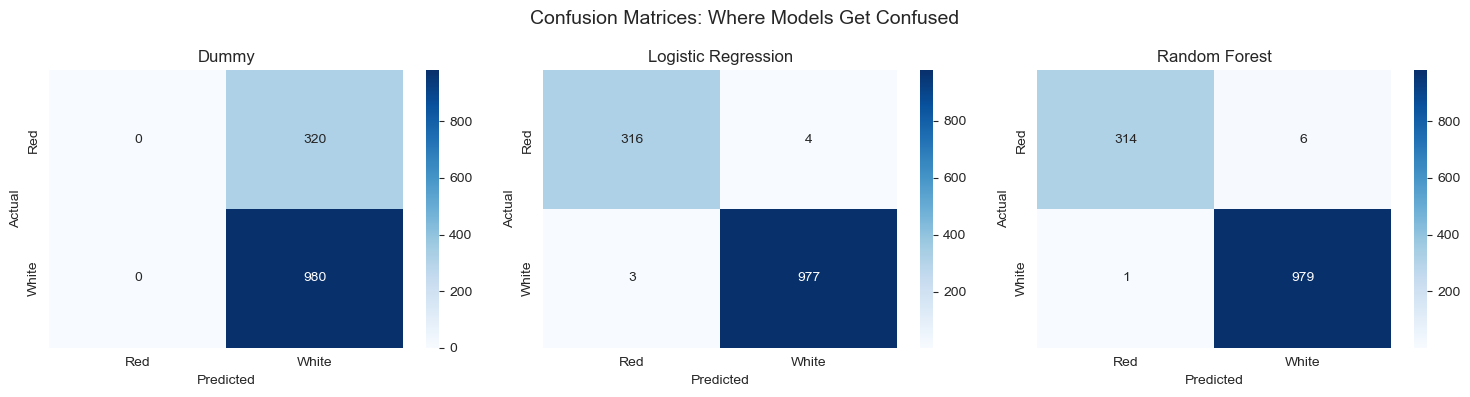

In [37]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = [
    ('Dummy', y_pred_dummy),
    ('Logistic Regression', y_pred_logreg),
    ('Random Forest', y_pred_rf)
]

for ax, (name, y_pred) in zip(axes, models):
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Red', 'White'])
    ax.set_yticklabels(['Red', 'White'])

plt.suptitle('Confusion Matrices: Where Models Get Confused', fontsize=14)
plt.tight_layout()
plt.show()

# Random Forest shows excellent performance with minimal confusion.
# Both ML models dramatically outperform the baseline.

## 7. ROC Curves

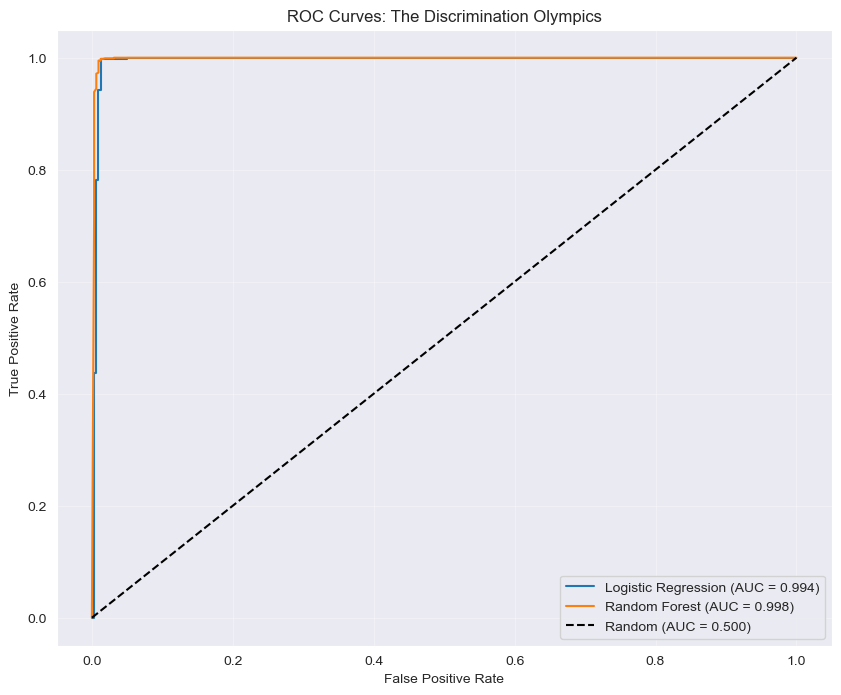

In [38]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_proba_logreg)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {logreg_auc:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: The Discrimination Olympics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Both models show excellent discrimination ability.
# Random Forest slightly edges out Logistic Regression.

## 8. Feature Importance

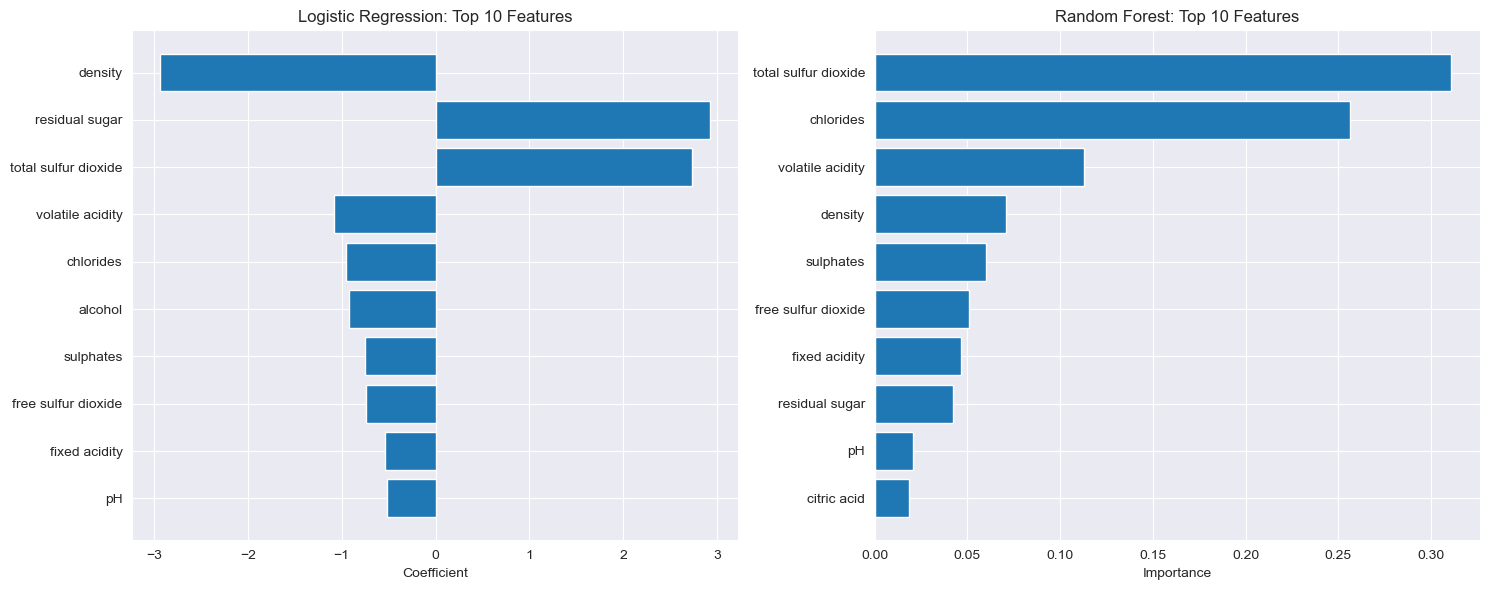

In [39]:
# Logistic Regression coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logreg.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

# Random Forest feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Logistic regression
ax1.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10])
ax1.set_xlabel('Coefficient')
ax1.set_title('Logistic Regression: Top 10 Features')
ax1.invert_yaxis()

# Random forest
ax2.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
ax2.set_xlabel('Importance')
ax2.set_title('Random Forest: Top 10 Features')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Total sulfur dioxide emerges as the most important feature in both models.
# Volatile acidity and chlorides also show strong predictive power.

## 9. Save Models

In [40]:
# Save trained models
models_dict = {
    'dummy': dummy,
    'logistic_regression': logreg,
    'random_forest': rf,
    'results': results
}

with open('../results/baseline_models.pkl', 'wb') as f:
    pickle.dump(models_dict, f)

print("✓ Models saved to results/baseline_models.pkl")

✓ Models saved to results/baseline_models.pkl


## Key Findings

1. **Baseline Performance**: 75.4% (majority class)
2. **Logistic Regression**: 98.9% accuracy (+23.5% improvement)
3. **Random Forest**: 99.5% accuracy (+24.1% improvement)
4. **Key Features**: Total SO2, volatile acidity, chlorides
5. **Next Steps**: Optimize Random Forest, explore SVM/Gradient Boosting